In [2]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

In [3]:
expdir='/Volumes/ukps-all$/user/tdanko/Students/Gabriel/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [4]:
dfhya=pd.read_pickle(expdir+'Hyaturnover_df2.pkl')
dfwfa=pd.read_pickle(expdir+'WFAturnover_df2.pkl')
dfncan=pd.read_pickle(expdir+'NCANturnover_df2.pkl')

In [5]:
dfhya['Protein']='Hyaluronan'
dfwfa['Protein']='WFA'
dfncan['Protein']='Ncan'

In [6]:
df2=pd.concat([dfhya,dfwfa,dfncan])
df2=df2.reset_index()

In [7]:
var="ECM mean intensity after bg subtraction: matlab manual mask only" #change me

means={"protein":[],"expname":[],"Time":[],"intensity normd 0 to 1":[], "0 to 1 intensity normd to unblocked mean":[],
      "intensity normd to 2hr":[]}

df2read=df2[(df2["expname"]!="20190206_NCAN_analyse")]
           #& (df2["expname"]!="20181113_NCAN_analyse")]


for exp in df2read["expname"].unique():
    dfcalc=df2read[df2read["expname"]==exp]
    
    means["expname"].append(exp)
    
    means["Time"].append('No Blocking')
    

    dfcalc2=dfcalc[dfcalc["Time"]=="No Blocking"]
    
    protein=dfcalc2["Protein"].unique()[0]
    means["protein"].append(protein+' -No blocking')
    diomean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(diomean)
    means["0 to 1 intensity normd to unblocked mean"].append(1)
    
    
    #means["intensity normd to 2hr"].append(np.nan)
    
    means["expname"].append(exp)
    
    means["Time"].append('2hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="2hrs"]
    means["protein"].append(protein)
    twelvemean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)    
    
    means["intensity normd to 2hr"].append(diomean/twelvemean)
    means["intensity normd to 2hr"].append(1)
    
    means["expname"].append(exp)
    
    means["Time"].append('4hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="4hrs"]
    means["protein"].append(protein)
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
    means["expname"].append(exp)
    
    means["Time"].append('12hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="12hrs"]
    means["protein"].append(protein)
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
    
    
    
    
dfmeans=pd.DataFrame(means)

KeyError: 'Hyaluronan'

<Figure size 432x288 with 0 Axes>

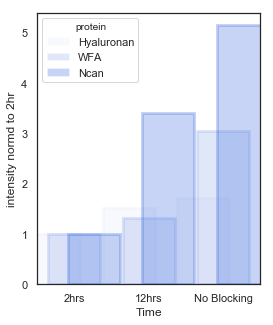

In [40]:
dfmeans=dfmeans.dropna()

sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

#y="intensity normd 0 to 1"
var="intensity normd to 2hr"
#y="intensity raw"
#y="raw intensity normd to dio mean"
fig=plt.figure(figsize=(4,5))
order=['2hrs','12hrs','No Blocking']
#palette ={"No Blocking":"gray","2hrs":"#2F67F8","12hrs":"#2F67F8"}

g=sns.barplot(x="Time",hue="protein",y=var,data=dfmeans,alpha=0.3,ci=None,color="#2F67F8",order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        #change edgecolor
        clr = patch.get_facecolor()
        patch.set_edgecolor(clr)
        #patch.set_edgewidth(3)
        #patch.set_linewidth(10)
        patch.set_linewidth(3)
change_width(g, .7)

g=sns.swarmplot(x="Time",hue="protein",y=var,data=dfmeans,size=10,palette=palette,linewidth=1,order=order)

plt.errorbar(x=[2,1],
             y=[dfmeans[dfmeans["Time"]=="No Blocking"][var].mean(),
             
             
             dfmeans[dfmeans["Time"]=="12hrs"][var].mean()],
             yerr=[dfmeans[dfmeans["Time"]=="No Blocking"][var].sem(),
             
             
             dfmeans[dfmeans["Time"]=="12hrs"][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,zorder=10,
            alpha=.7)

'''g.hlines(dfmeans[dfmeans["Time"]=="No Blocking"][y].mean(), xmin=-0.5, xmax=0.5, linewidth=3, color='gray')
g.hlines(dfmeans[dfmeans["Time"]=="2hrs"][y].mean(), xmin=0.6, xmax=1.5, linewidth=3, color='magenta')
g.hlines(dfmeans[dfmeans["Time"]=="4hrs"][y].mean(), xmin=1.6, xmax=2.5, linewidth=3, color='magenta')
g.hlines(dfmeans[dfmeans["Time"]=="12hrs"][y].mean(), xmin=1.6, xmax=2.5, linewidth=3, color='magenta')'''

#scale_y=1/100
#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
#g.yaxis.set_major_formatter(ticks_y)
g.set_ylabel('Normalised Fluorescence intensity',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',color='black',alpha=.7)
plt.xticks(g.get_xticks(),size=20,rotation=45)
plt.yticks(g.get_yticks(),size=18)
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

#plt.ylim([0/100,1/100])
plt.xlim([-1,3])


x1, x2 = 0,1
y= 5
h=0.01*dfmeans[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')



from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

varx = [0.,1.,2.]
vary = [dfmeans[dfmeans["Time"]=="2hrs"][var].mean(),
     
     dfmeans[dfmeans["Time"]=="12hrs"][var].mean(),
     dfmeans[dfmeans["Time"]=="No Blocking"][var].mean()]

from scipy.interpolate import spline

#xnew = np.linspace(min(x), max(x), 10)

#y_smooth = spline(varx, vary, xnew)

#plt.plot(xnew, y_smooth)

plt.yticks([1,3,5,7])
plt.xticks(g.get_xticks(),['2h','12h','No Blocking'])
plt.ylim([0,9])



diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'1b_allproteins.svg', bbox_inches='tight', format='svg')




